# Computational Checks
Tim Tyree<br>
8.18.2020

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
from numba import njit
#load the libraries
# from lib import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [2]:
def import_fortran_texture(file_name):
    fn = file_name
    data_ic = np.loadtxt(fn)
    cols = ['i','j','u','v','w']
    df = pd.DataFrame(data_ic, columns=cols)
    df.head()
    target_shape = df.describe()[['i','j']].T['max'].values
    ic = df[['u','v','w']].values
    ic = ic.reshape((int(target_shape[0]),int(target_shape[1]),3), order='F')
    return ic

# load and visualize the initial/final buffers

In [3]:
#find file interactively
# print("please select a file from within the desired folder.")
# file = search_for_file()
file = '/Users/timothytyree/Documents/GitHub/care/Python/computational-checks/input_half'

In [4]:
folder_name = os.path.dirname(file)
os.chdir(folder_name)
# retval = !ls

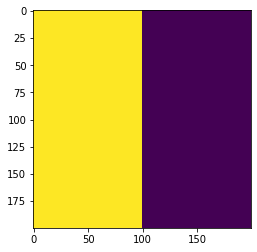

In [5]:
fn = 'input_half'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

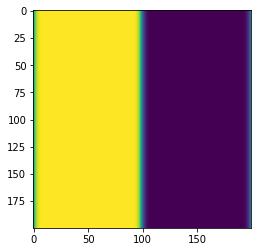

In [6]:
fn = 'output_half'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

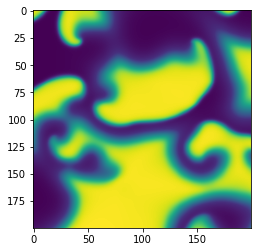

In [7]:
fn = 'input_disorder'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

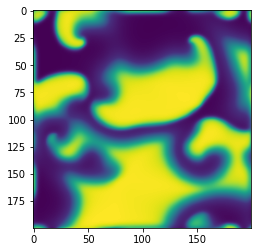

In [8]:
fn = 'output_disorder'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

## visualize cross section of the half io textures

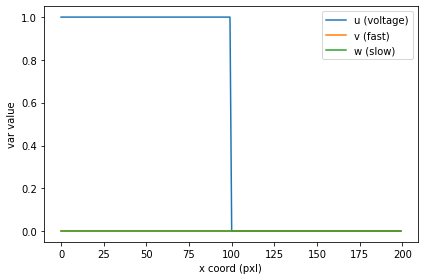

In [9]:
fn = 'input_half'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)
save = True

plt.plot(ic[100,:,0], label='u (voltage)')
plt.plot(ic[100,:,2], label='v (fast)')
plt.plot(ic[100,:,1], label='w (slow)')
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

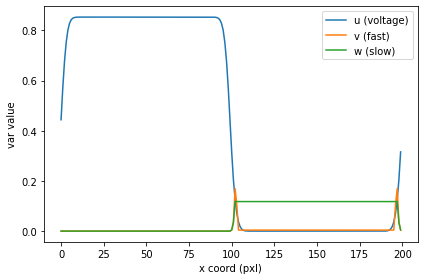

In [10]:
fn = 'output_half'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)
save = True

plt.plot(ic[100,:,0], label='u (voltage)')
plt.plot(ic[100,:,1], label='v (fast)')
plt.plot(ic[100,:,2], label='w (slow)')
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

# define my time_step

In [9]:
# @njit
# def Tanh(x):
# 	'''fast/simple approximatation of the hyperbolic tangent function'''
# 	if ( x < -3.):
# 		return -1.
# 	elif ( x > 3. ):
# 		return 1.
# 	else:
# 		return x*(27.+x*x)/(27.+9.*x*x)

@njit
def Tanh(x):
    return np.math.tanh(x)
    
# /*------------------------------------------------------------------------
#  * applying periodic boundary conditions for each texture call
#  *------------------------------------------------------------------------
#  */
@njit
def pbc(S,x,y):
    '''S=texture with size 512,512,3
    (x, y) pixel coordinates of texture with values 0 to 1.
    tight boundary rounding is in use.'''
    width  = int(S.shape[0])
    height = int(S.shape[1])
    if ( x < 0  ):				# // Left P.B.C.
        x = width - 1
    elif ( x > (width - 1) ):	# // Right P.B.C.
        x = 0
    if( y < 0 ):				# //  Bottom P.B.C.
        y = height - 1
    elif ( y > (height - 1)):	# // Top P.B.C.
        y = 0
    return S[x,y]

@njit
def pbc1(S,x,y):
	'''S=texture with size 512,512,1
	(x, y) pixel coordinates of texture with values 0 to 1.
	tight boundary rounding is in use.'''
	width  = int(S.shape[0])
	height = int(S.shape[1])
	if ( x < 0  ):				# // Left P.B.C.
		x = width - 1
	elif ( x > (width - 1) ):	# // Right P.B.C.
		x = 0
	if( y < 0 ):				# //  Bottom P.B.C.
		y = height - 1
	elif ( y > (height - 1)):	# // Top P.B.C.
		y = 0
	return S[x,y]

# step function
@njit
def step(a,b):
    return 1 if a<=b else 0 # nan yields 1

# /*------------------------------------------------------------------------
#  * time step at a pixel
#  *------------------------------------------------------------------------
#  */
@njit
def time_step_at_pixel(inVfs, x, y):#, h):
    # define parameters
    width    = int(inVfs.shape[0])
    height   = int(inVfs.shape[1])
    DX       = 0.025 #cm/pxl
    DY       = 0.025 #cm/pxl
    cddx     = 1/DX**2
    cddy     = 1/DY**2
    diffCoef = 0.0005 # cm^2 / ms
    C_m      = 1.000  # 􏰎microFarad/cm^2 

    #parameter set 8 of FK model from Fenton & Cherry (2002)
    tau_pv   = 13.03
    tau_v1   = 19.6
    tau_v2   = 1250
    tau_pw   = 800
    tau_mw   = 40
    tau_d    = 0.45# also interesting to try, but not F&C8's 0.45: 0.407#0.40#0.6#
    tau_0    = 12.5
    tau_r    = 33.25
    tau_si   = 29#
    K        = 10
    V_sic    = 0.85#
    V_c      = 0.13
    V_v      = 0.04
    C_si     = 1  # I didn't find this (trivial) multiplicative constant in Fenton & Cherry (2002).  The value C_si = 1 was used in Kaboudian (2019).
    dx, dy   = (1, 1)# (1/512, 1/512) # size of a pixel

    # /*------------------------------------------------------------------------
    #  * reading from textures
    #  *------------------------------------------------------------------------
    #  */
    C = pbc(inVfs, x, y)
    vlt = C[0]#volts
    fig = C[1]#fast var
    sig = C[2]#slow var

    # /*-------------------------------------------------------------------------
    #  * Calculating right hand side vars
    #  *-------------------------------------------------------------------------
    #  */
    p = step(V_c, vlt)
    q = step(V_v, vlt)
    
    #original FK model
    #     tau_mv = (1.0 - q) * tau_v1 + q * tau_v2
    #FK model with tau_v2 and tau_v1 switched
    tau_mv = (1.0 - q) * tau_v2 + q * tau_v1
    
    Ifi = -fig * p * (vlt - V_c) * (1.0 - vlt) / tau_d
    Iso = vlt * (1.0 - p) / tau_0 + p / tau_r

    tn = Tanh(K * (vlt - V_sic))
    Isi = -sig * (1.0 + tn) / (2.0 * tau_si)
    Isi *= C_si
    dFig2dt = (1.0 - p) * (1.0 - fig) / tau_mv - p * fig / tau_pv
    dSig2dt = (1.0 - p) * (1.0 - sig) / tau_mw - p * sig / tau_pw

    #five point stencil
    dVlt2dt = (
        (pbc(inVfs, x + 1, y)[0] - 2.0 * C[0] +
         pbc(inVfs, x - 1, y)[0]) * cddx +
        (pbc(inVfs, x, y + 1)[0] - 2.0 * C[0] +
         pbc(inVfs, x, y - 1)[0]) * cddy)
    dVlt2dt *= diffCoef
    
    #(deprecated) nine point stencil
    # 	dVlt2dt = (1. - 1. / 3.) * (
    # 		(pbc(inVfs, x + 1, y)[0] - 2.0 * C[0] +
    # 		 pbc(inVfs, x - 1, y)[0]) * cddx +
    # 		(pbc(inVfs, x, y + 1)[0] - 2.0 * C[0] +
    # 		 pbc(inVfs, x, y - 1)[0]) * cddy) + (1. / 3.) * 0.5 * (
    # 			 pbc(inVfs, x + 1, y + 1)[0] + pbc(
    # 				 inVfs, x + 1, y - 1)[0] + pbc(inVfs, x - 1, y - 1)[0] +
    # 			 pbc(inVfs, x - 1, y + 1)[0] - 4.0 * C[0]) * (cddx + cddy)
    # 	dVlt2dt *= diffCoef
    
    I_sum = Isi + Ifi + Iso
    dVlt2dt -= I_sum / C_m
    return np.array((dVlt2dt,dFig2dt,dSig2dt),dtype=np.float64)

@njit
def get_time_step (texture, out):
    width  = int(texture.shape[0])
    height = int(texture.shape[1])
    for x in range(width):
        for y in range(height):
            out[x,y] = time_step_at_pixel(texture,x,y)

@njit # or perhaps @jit, which probably won't speed up time_step
def time_step (texture, h, zero_txt):
    dtexture_dt = zero_txt.copy()
    get_time_step(texture, dtexture_dt)
    texture += h * dtexture_dt

# load half ic and apply my time_step

In [32]:
fn = 'input_half'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)

In [33]:
txt = ic.copy()
zero_txt = 0.*txt.copy()
h = 0.1

In [34]:
for j in range(50):
    time_step(texture=txt, h=h, zero_txt=zero_txt)
txt_out = txt.copy()

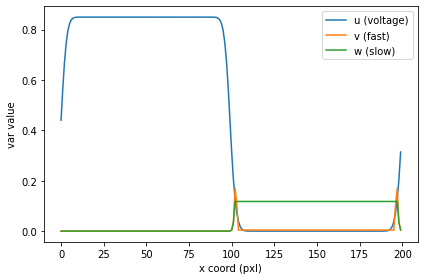

In [35]:
save = True
save_fn = f'fig/{fn}_tt_tau_v1221.png'
plt.plot(txt_out[100,:,0], label='u (voltage)')
plt.plot(txt_out[100,:,1], label='v (fast)')
plt.plot(txt_out[100,:,2], label='w (slow)')
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

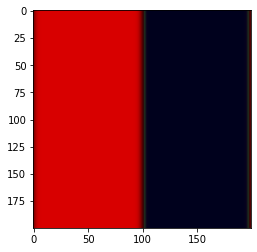

In [15]:
plt.imshow(txt_out)

# our numerical values do not agree, and I can't tell why.  
Thus, I will 
- TODO: quantify the numerical difference between test B (chaotic) in terms of (printing) MSD
- TODO: skim WJ's fortran to try to find out why both of my auxiliary variables jump while only one of his does (control+ F for v)
- TODO: put it all into a .pdf visualization and share!

In [16]:
fn = 'input_disorder'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)

In [17]:
txt = ic.copy()
zero_txt = 0.*txt.copy()
h = 0.1
for j in range(50):
    time_step(texture=txt, h=h, zero_txt=zero_txt)
txt_out = txt.copy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


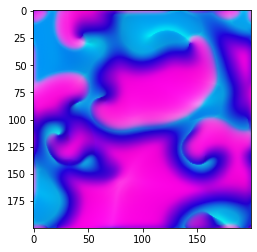

In [18]:
plt.imshow(txt_out)

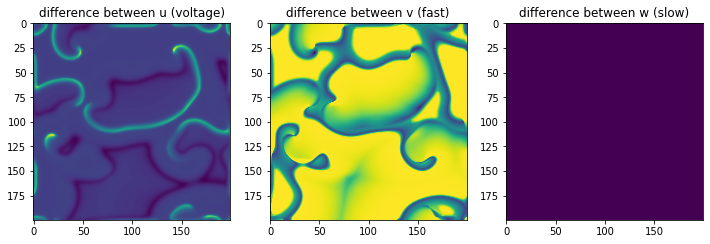

In [27]:
fn = 'output_disorder'
save_fn = f'fig/differences_tau_v1221.png'
wj_out = import_fortran_texture(fn)

diff = wj_out-txt_out
fig, axs = plt.subplots(ncols = 3, figsize=(12,4))

ax = axs[0]
ax.imshow(diff[...,0])
ax.set_title('difference between u (voltage)')
ax = axs[1]
ax.imshow(diff[...,1])
ax.set_title('difference between v (fast)')
ax = axs[2]
ax.imshow(diff[...,2])
ax.set_title('difference between w (slow)')
fig.savefig(save_fn)


In [30]:
MSD = sum(diff.flatten()**2)
# print(f"The repolarized regions of our fast variables appear to disagree.")
print(f"The mean squared difference between u is {sum(diff[...,0].flatten()**2)}")
print(f"The mean squared difference between v is {sum(diff[...,1].flatten()**2)}")
print(f"The mean squared difference between w is {sum(diff[...,2].flatten()**2)}")

The mean squared difference between u is 5.62114650168146e-12
The mean squared difference between v is 9.238808252685931e-14
The mean squared difference between w is 0.0


In [29]:
diff[...,0]

array([[1.78710267e-08, 1.39555816e-08, 1.08022334e-08, ...,
        4.19369758e-08, 3.11217947e-08, 2.24614951e-08],
       [1.43297136e-08, 8.67727701e-09, 4.45287907e-09, ...,
        4.74182180e-08, 3.24334412e-08, 2.08353461e-08],
       [1.14968202e-08, 4.93195595e-09, 4.99342234e-10, ...,
        4.78421492e-08, 3.15033238e-08, 1.89111428e-08],
       ...,
       [3.47241773e-08, 4.08363301e-08, 4.19451474e-08, ...,
        6.01551729e-09, 1.06637010e-08, 1.80231910e-08],
       [2.80089015e-08, 2.99920958e-08, 2.94487612e-08, ...,
        1.19823355e-08, 1.44148949e-08, 1.90509717e-08],
       [2.18176328e-08, 2.04494589e-08, 1.85865875e-08, ...,
        2.19743611e-08, 2.09047388e-08, 2.03991181e-08]])